### ติดตั้งและ import library ต่างๆ

In [ ]:
!pip install ktrain -q

In [ ]:
!pip uninstall keras tensorflow -y
!pip install tensorflow==2.11.0 keras==2.11.0

In [ ]:
!pip install transformers==4.26.1
!pip install ktrain==0.35.0

In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import numpy as np
import ktrain
from ktrain import text

### เตรียมข้อมูล

In [ ]:
splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/Wongnai/wongnai_reviews/" + splits["train"])

df.head()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,review_body,star_rating
0,ร้านอาหารใหญ่มากกกกกกก \nเลี้ยวเข้ามาเจอห้องน้...,2
1,อาหารที่นี่เป็นอาหารจีนแคะที่หากินยากในบ้านเรา...,3
2,ปอเปี๊ยะสด ทุกวันนี้รู้สึกว่าหากินยาก (ร้านที่...,2
3,รัานคัพเค้กในเมืองไทยมีไม่มาก หลายๆคนอาจจะสงสั...,4
4,อร่อย!!! เดินผ่านDigital gatewayทุกวัน ไม่ยักร...,4


In [ ]:
# แปลงคะแนนเป็น labels: 'positive' และ 'negative'
df['sentiment'] = df['star_rating'].apply(lambda x: 'positive' if x >= 4 else 'negative')

df.head()

,review_body,star_rating,sentiment
0,ร้านอาหารใหญ่มากกกกกกก \nเลี้ยวเข้ามาเจอห้องน้...,2,negative
1,อาหารที่นี่เป็นอาหารจีนแคะที่หากินยากในบ้านเรา...,3,negative
2,ปอเปี๊ยะสด ทุกวันนี้รู้สึกว่าหากินยาก (ร้านที่...,2,negative
3,รัานคัพเค้กในเมืองไทยมีไม่มาก หลายๆคนอาจจะสงสั...,4,positive
4,อร่อย!!! เดินผ่านDigital gatewayทุกวัน ไม่ยักร...,4,positive


In [ ]:
df_cleaned = df.dropna(subset=['star_rating'])

In [ ]:
df = df_cleaned.iloc[:5000]
df.shape

(5000, 3)

In [ ]:
# ใช้ pd.factorize() เพื่อสร้างตัวเลขแทนค่าคะแนน
labels, class_names = pd.factorize(df.sentiment)

# เปลี่ยน class names ให้เป็น list
class_names = class_names.tolist()

print(class_names)

['negative', 'positive']


### เตรียมข้อมูล train และ test

In [ ]:
from sklearn.model_selection import train_test_split

X_train , X_test, y_train, y_test = train_test_split(df['review_body'], df['sentiment'], test_size=0.2, random_state=42)

X_train.shape, X_test.shape

((4000,), (1000,))

ติดตั้ง pretrained model BERT : "airesearch/wangchanberta-base-att-spm-uncased"

In [ ]:
pretrain_model = "airesearch/wangchanberta-base-att-spm-uncased"
transformer = text.Transformer(pretrain_model, maxlen=160, class_names=class_names)

สถาปัตยกรรม BERT (Bidirectional Encoder Representations from Transformers) จะทำ processing ส่วนของ train และ test ไม่เหมือนกัน

In [ ]:
train = transformer.preprocess_train(X_train.to_list(), y_train.to_list())
test = transformer.preprocess_test(X_test.to_list(), y_test.to_list())

preprocessing train...
language: th
train sequence lengths:
	mean : 37
	95percentile : 104
	99percentile : 161


/usr/local/lib/python3.10/dist-packages/ktrain/utils.py:744: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  warnings.warn(


Is Multi-Label? False
preprocessing test...
language: th
test sequence lengths:
	mean : 36
	95percentile : 96
	99percentile : 151


เนื่องจาก output ขึ้น UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset จึงทำการตรวจเช็ค classes

In [ ]:
print(transformer.get_classes())

['negative', 'positive']


ตรวจสอบมิติ X,y หลังจากที่ผ่านการ Preprocessing แล้ว

In [ ]:
train.x.shape, train.y.shape

((4000, 3, 160), (4000, 2))

ถ้าเป็นข้อความ: 4000 ตัวอย่างข้อความ

แต่ละตัวอย่างมี 3 embeddings (e.g., Token embeddings, Positional embeddings, Segment embeddings)

แต่ละ embedding มีความยาว 160 token

In [ ]:
train.x

array([[[    5,    10,  9619, ...,  1269,    10,     6],
        [    1,     1,     1, ...,     1,     1,     1],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[    5,  3865,  3564, ...,  4487, 13560,     6],
        [    1,     1,     1, ...,     1,     1,     1],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[    5,  6172, 13414, ...,     1,     1,     1],
        [    1,     1,     1, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       ...,

       [[    5,  6172,  4791, ...,     6,     1,     1],
        [    1,     1,     1, ...,     1,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[    5,    10,  1577, ...,  2548,   195,     6],
        [    1,     1,     1, ...,     1,     1,     1],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[    5,    10,  4920, ...,     6,     1,     1],
        [    1,     1,     1, ...,     1,     0,     0],
        

### สร้างโมเดล

In [ ]:
model = transformer.get_classifier()

### Train1

In [ ]:
learner = ktrain.get_learner(model, train_data=train, val_data=test, batch_size=16)

In [ ]:
import tensorflow as tf
import keras
import transformers
import ktrain

print(f"TensorFlow: {tf.__version__}")
print(f"Keras: {keras.__version__}")
print(f"Transformers: {transformers.__version__}")
print(f"Ktrain: {ktrain.__version__}")


TensorFlow: 2.11.0
Keras: 2.11.0
Transformers: 4.26.1
Ktrain: 0.35.0


In [ ]:
learner.lr_find(max_epochs = 1)  # ลดจำนวน epochs ในการค้นหา

simulating training for different learning rates... this may take a few moments...
250/250 [==============================] - 6356s 25s/step - loss: 7.2587 - accuracy: 0.8017


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


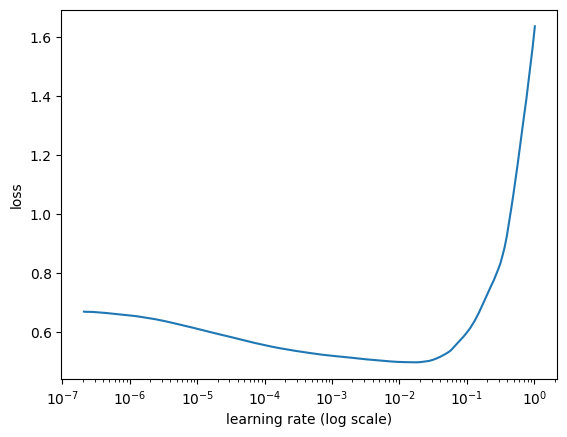

In [ ]:
learner.lr_plot()

In [ ]:
learner.fit_onecycle(5e-3, 1)



begin training using onecycle policy with max lr of 0.005...
250/250 [==============================] - 7506s 30s/step - loss: 0.4577 - accuracy: 0.8568 - val_loss: 0.4184 - val_accuracy: 0.8540


In [ ]:
learner.validate(class_names=transformer.get_classes())

32/32 [==============================] - 562s 17s/step
              precision    recall  f1-score   support

    negative       0.85      1.00      0.92       854
    positive       0.00      0.00      0.00       146

    accuracy                           0.85      1000
   macro avg       0.43      0.50      0.46      1000
weighted avg       0.73      0.85      0.79      1000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


array([[854,   0],
       [146,   0]])

In [ ]:
learner.view_top_losses(n=3, preproc=transformer)

32/32 [==============================] - 544s 17s/step
----------
id:13 | loss:2.11 | true:positive | pred:negative)

----------
id:22 | loss:2.11 | true:positive | pred:negative)

----------
id:39 | loss:2.11 | true:positive | pred:negative)



In [ ]:
X_test.iloc[22]

'ด้วยความปราณีตและสร้างสรรค์อย่างมีศิลปะในแบบฉบับของอาหาร จากแดนอาทิตย์อุทัยแท้ ๆ “ฮากิ” มีเมนูหลากหลายให้คุณได้เลือกรับประทานมากกว่า 50 ชนิด ท่ามกลางบรรยากาศแบบญี่ปุ่น หรือเลือกรับประทานในห้องเพื่อความเป็นส่วนตัวถึง 7 ห้อง\n\nนอกจากนี้ทุกวันหยุดสุดสัปดาห์และวันหยุดนักขัตฤกษ์เรายังมีบุฟเฟต์ตามสั่งให้รับประทานกันอย่างจุใจค่ะ\n\nราคา 650++ บาท ต่อคนค่ะ\n\nเปิดบริการ :ทุกวัน เวลา: 11.30-14.30, 18.00-22.30 น.\n\nสำรองที่นั่งและสอบถามเพิ่มเติมได้ที่ โทร. 025411234#4081\n'

## แก้ปัญหา Imbalance : oversampling

In [ ]:
# ตรวจสอบจำนวนตัวอย่างในแต่ละคลาส
class_counts = df['sentiment'].value_counts()

# แสดงผลจำนวนตัวอย่าง
for label, count in class_counts.items():
    print(f"คลาส: {label}, จำนวน: {count}")


คลาส: negative, จำนวน: 4314
คลาส: positive, จำนวน: 686


In [ ]:
# 1. เก็บ text ดิบและทำ mapping
X = df['review_body'].values
y = df['sentiment'].map({'negative': 0, 'positive': 1}).values
text_mapping = {i: text for i, text in enumerate(X)}

# 2. แปลงข้อความเป็น TF-IDF vectors
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X_vectorized = vectorizer.fit_transform(X)

# 3. ใช้ SMOTE และ RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# 4. ทำ SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_vectorized, y)

In [ ]:
# ทำ undersampling ให้แต่ละคลาสเหลือประมาณ 2,500 ตัวอย่าง
rus = RandomUnderSampler(sampling_strategy={0: 2500, 1: 2500}, random_state=42)
X_final, y_final = rus.fit_resample(X_smote, y_smote)

# ตรวจสอบจำนวนข้อมูลสุดท้าย
print("จำนวนข้อมูลหลัง final undersampling:")
print(pd.Series(y_final).value_counts())

จำนวนข้อมูลหลัง final undersampling:
0    2500
1    2500
Name: count, dtype: int64


## Train2

In [ ]:
from sklearn.model_selection import train_test_split

X_train_vec, X_test_vec, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

In [ ]:
# 6. แปลง vector กลับเป็น text
X_train = [str(x) for x in X_train_vec]
X_test = [str(x) for x in X_test_vec]

In [ ]:
pretrain_model = "airesearch/wangchanberta-base-att-spm-uncased"
transformer = text.Transformer(pretrain_model, maxlen=160, class_names=class_names)

config.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/423M [00:00<?, ?B/s]

In [ ]:
# 7. ใช้กับ transformer
train = transformer.preprocess_train(X_train, y_train.tolist())
test = transformer.preprocess_test(X_test, y_test.tolist())

preprocessing train...


/usr/local/lib/python3.10/dist-packages/ktrain/text/textutils.py:265: UserWarning: Defaulting to English for language detection: could not detect language from documents. This may be due to empty or invalid texts being provided to detect_lang.
  warnings.warn(


language: en
train sequence lengths:
	mean : 139
	95percentile : 152
	99percentile : 152


tokenizer_config.json:   0%|          | 0.00/282 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/905k [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 139
	95percentile : 152
	99percentile : 152


In [ ]:
print(transformer.get_classes())

['negative', 'positive']


In [ ]:
model = transformer.get_classifier()

In [ ]:
learner = ktrain.get_learner(model, train_data=train, val_data=test, batch_size=16)

In [ ]:
learner.lr_find(max_epochs = 1)  # ลดจำนวน epochs ในการค้นหา

simulating training for different learning rates... this may take a few moments...
250/250 [==============================] - 6283s 25s/step - loss: 12.6027 - accuracy: 0.5003


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


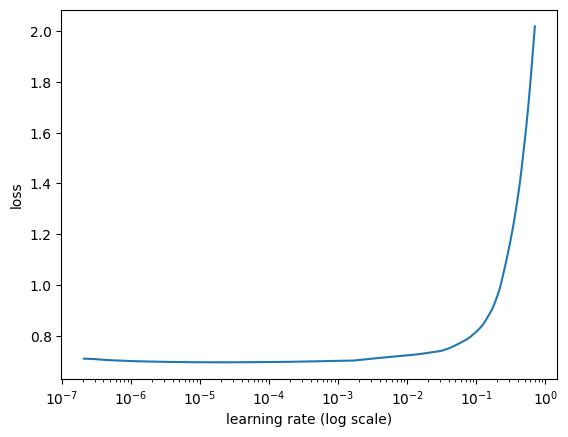

In [ ]:
learner.lr_plot()

In [ ]:
learner.fit_onecycle(1e-5, 1)



begin training using onecycle policy with max lr of 1e-05...
250/250 [==============================] - 7705s 31s/step - loss: 0.5661 - accuracy: 0.6793 - val_loss: 0.3123 - val_accuracy: 0.8870


In [ ]:
learner.validate(class_names=transformer.get_classes())

32/32 [==============================] - 636s 20s/step
              precision    recall  f1-score   support

    negative       0.85      0.94      0.89       500
    positive       0.93      0.84      0.88       500

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000



array([[468,  32],
       [ 81, 419]])